## Mapping Census Data

This example goes through how to interact with the Census API to download data on US households across space and time. We will go through the steps of obtaining household income and educational attainment data and then use the Geopandas library to visualize the data in Brooklyn, NY.

**Goal:** by the end of this tutorial you will produce a choropleth map similar to:

![map lost](household_income.png)

------

### Step 1: Installing libraries

Before you begin any coding it is important to download all of the libraries we'll be using to complete the task. Libraries can be thought of as useful peices of code, that can be used in your programs. They are generally created by other experts around the internet and made available for developers to use, extend, and make edits to. For this task we will be using the following libraries:
- [pip](https://pip.pypa.io/en/stable/installing/) (pip is a package manager for python that allows coders to download libraries with ease)
- [pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html#installing-from-pypi)
- [geopandas](https://geopandas.org/install.html#installing-with-pip)
- [cenpy](https://pypi.org/project/cenpy/)
- [matplotlib](https://matplotlib.org/users/installing.html)


### Step 2: Import libraries
The next step will be to load all the libraries into our current session so we can access their functionality

In [1]:
import pandas as pd
import cenpy
import warnings
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import os
from io import BytesIO
from zipfile import ZipFile
import requests

### Step 3: Connect to the Census API
The below line of code specifies the data sources and year 
we are interested in (5 year estimates for 2018). We could change 
the year by change the last four characters.

In [2]:
conn = cenpy.products.APIConnection("ACSDT5Y2018")

### Step 4: Choose the type of data to download
The Census API has a lot of data! There are so many different topics (income, commuting patterns, to even internet access) it's nearly impossible to understand them all. 

Fortuntately, the data are organized well and it is just a matter of knowing where to look. Use the [table names doc](https://github.com/carlobailey/urban-data-science/blob/gh-pages/ACS/table_name_variables.md) to see a list of possible variables to download. 

The below example uses variables **B19013_001E** + **B15012_001E** which are household income, and the number of residents with bachelor degrees. Feel free to pick one, two or more other topics from the above table, and edit the *names* variable below:

In [5]:
names = ['B19013_001E', 'B15012_001E']

In [8]:
data = conn.query(names, 
                  geo_unit='block group', 
                  geo_filter={"state": "36", "county": "047"})
for name in names:
    data[name] = data[name].astype(float)
data['geoid'] = data['state'] + data['county'] + data['tract'] + data['block group']
data = data.replace(-666666666.0, np.nan)

To preview what the data looks like run

In [9]:
data.head()

,B19013_001E,B15012_001E,state,county,tract,block group,geoid
0,61450.0,545.0,36,047,021100,2,360470211002
1,63833.0,956.0,36,047,021700,2,360470217002
2,19979.0,136.0,36,047,025500,2,360470255002
3,41375.0,367.0,36,047,027100,2,360470271002
4,NaN,0.0,36,047,028000,0,360470280000


### Step 5: Download the spatial geometry
Census data is organized by variaous types of geographic units (e.g. state, county, zip-code, tract, etc). For example, it's possible to download household income data at the state level or zipcode level. In general, it's always best to get data at the smallest geographic level (which for the Census API is blockgroup) as it gives the most fidelity to your analysis. 

So in the next step we will download a series of shapefiles from the Census API website and merge it with the data we already have. The shapefiles contain the geometry for census blockgroups in NY. We could change the state by entering the corresponding state number below. Use the [states abbreviation](https://github.com/carlobailey/urban-data-science/blob/gh-pages/geography_crosswalks/states.md) table for a list of possible state numbers.

In [10]:
state = '36'
yr = '18'
url = 'https://www2.census.gov/geo/tiger/TIGER20%s/BG/tl_20%s_%s_bg.zip' % (yr, yr, state)
resp = requests.get(url).content
zipfiles = ZipFile(BytesIO(resp))
files = zipfiles.namelist()
_ = [zipfiles.extract(x, path='data/') for x in files]
shapefile = [x for x in files if x[-3:] == 'shp'][0]

### Step 6: Merge and visualize data
Finally, we will merge our geometry and income data so that we can use geopandas to create a choropleth map.

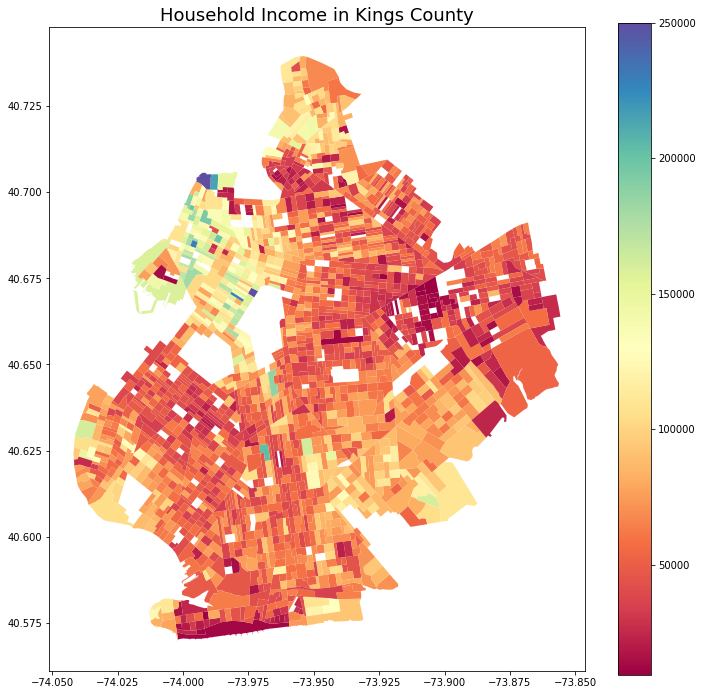

In [11]:
gdf = gpd.read_file('data/' + shapefile)
gdf = gdf.merge(data, left_on='GEOID', right_on='geoid')
gdf.dropna().plot(column=names[0], cmap='Spectral', legend=True, figsize=(12,12))
_ = plt.title('Household Income in Kings County', fontsize=18)